In [10]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

In [2]:
import kagglehub
path = kagglehub.dataset_download('shayanfazeli/heartbeat')

print(path)


Using Colab cache for faster access to the 'heartbeat' dataset.
/kaggle/input/heartbeat


**Load Data**

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


In [ ]:
train_df=pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv',header=None)
test_df=pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv',header=None)

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (87554, 188)
Test shape: (21892, 188)


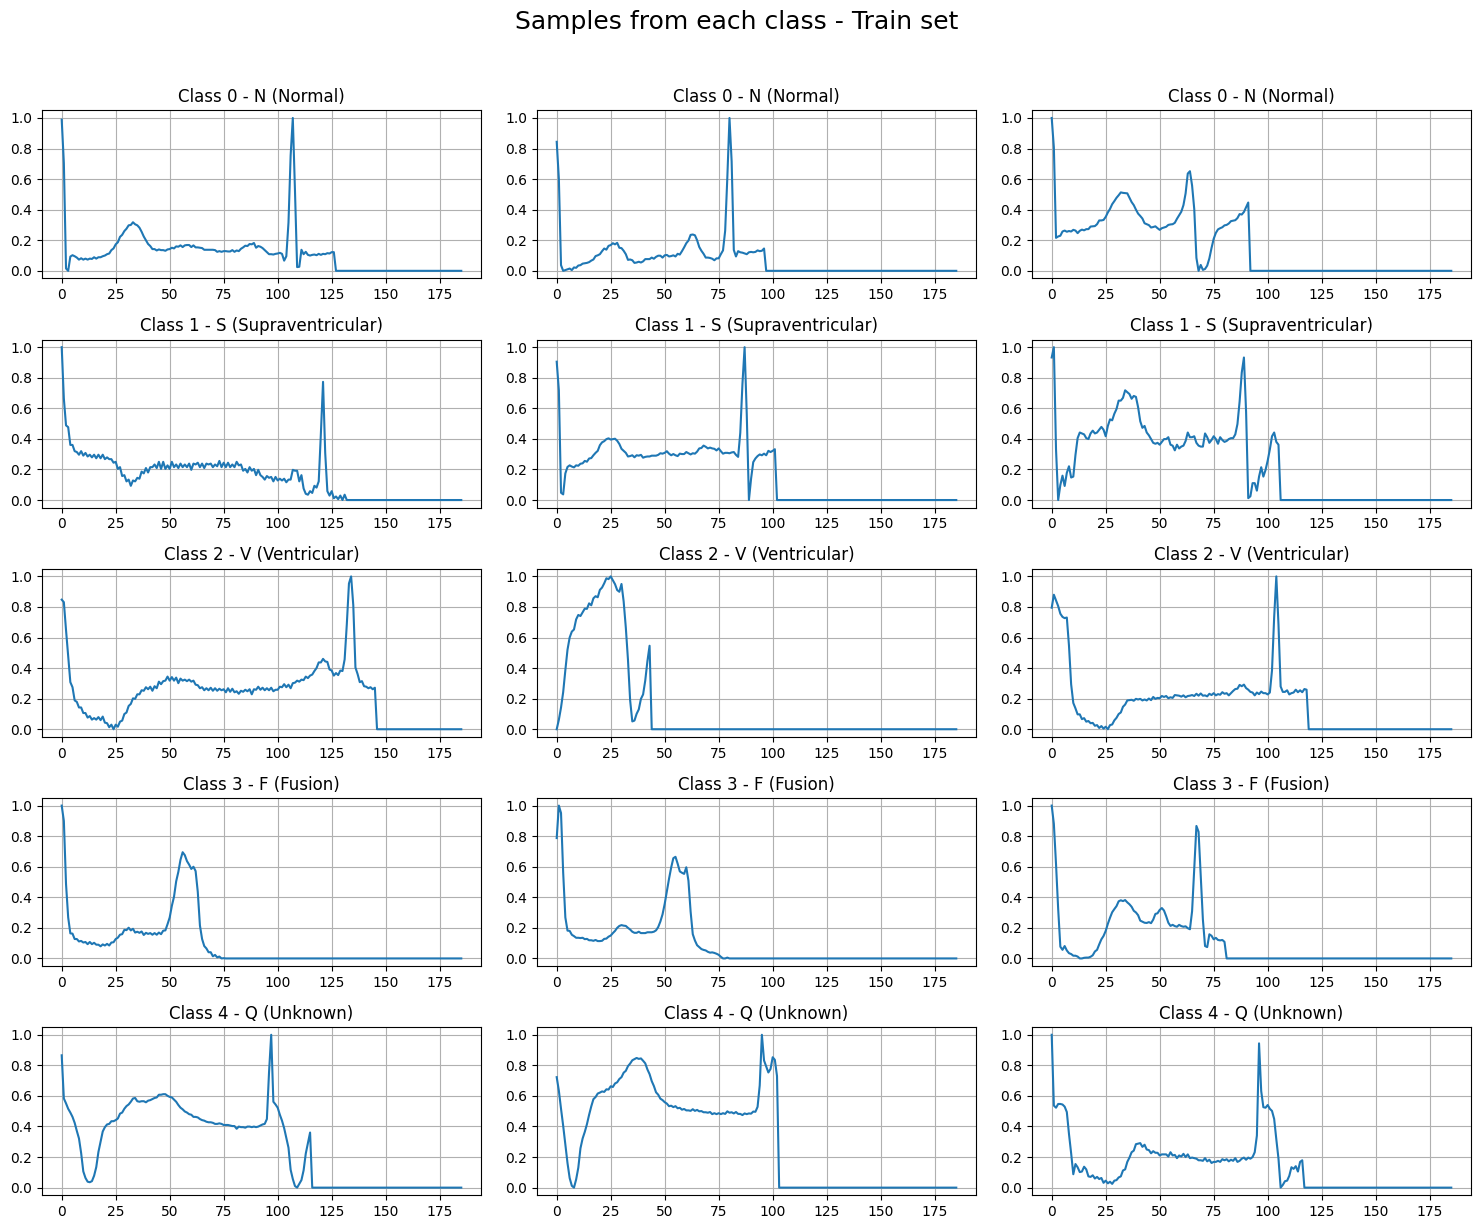

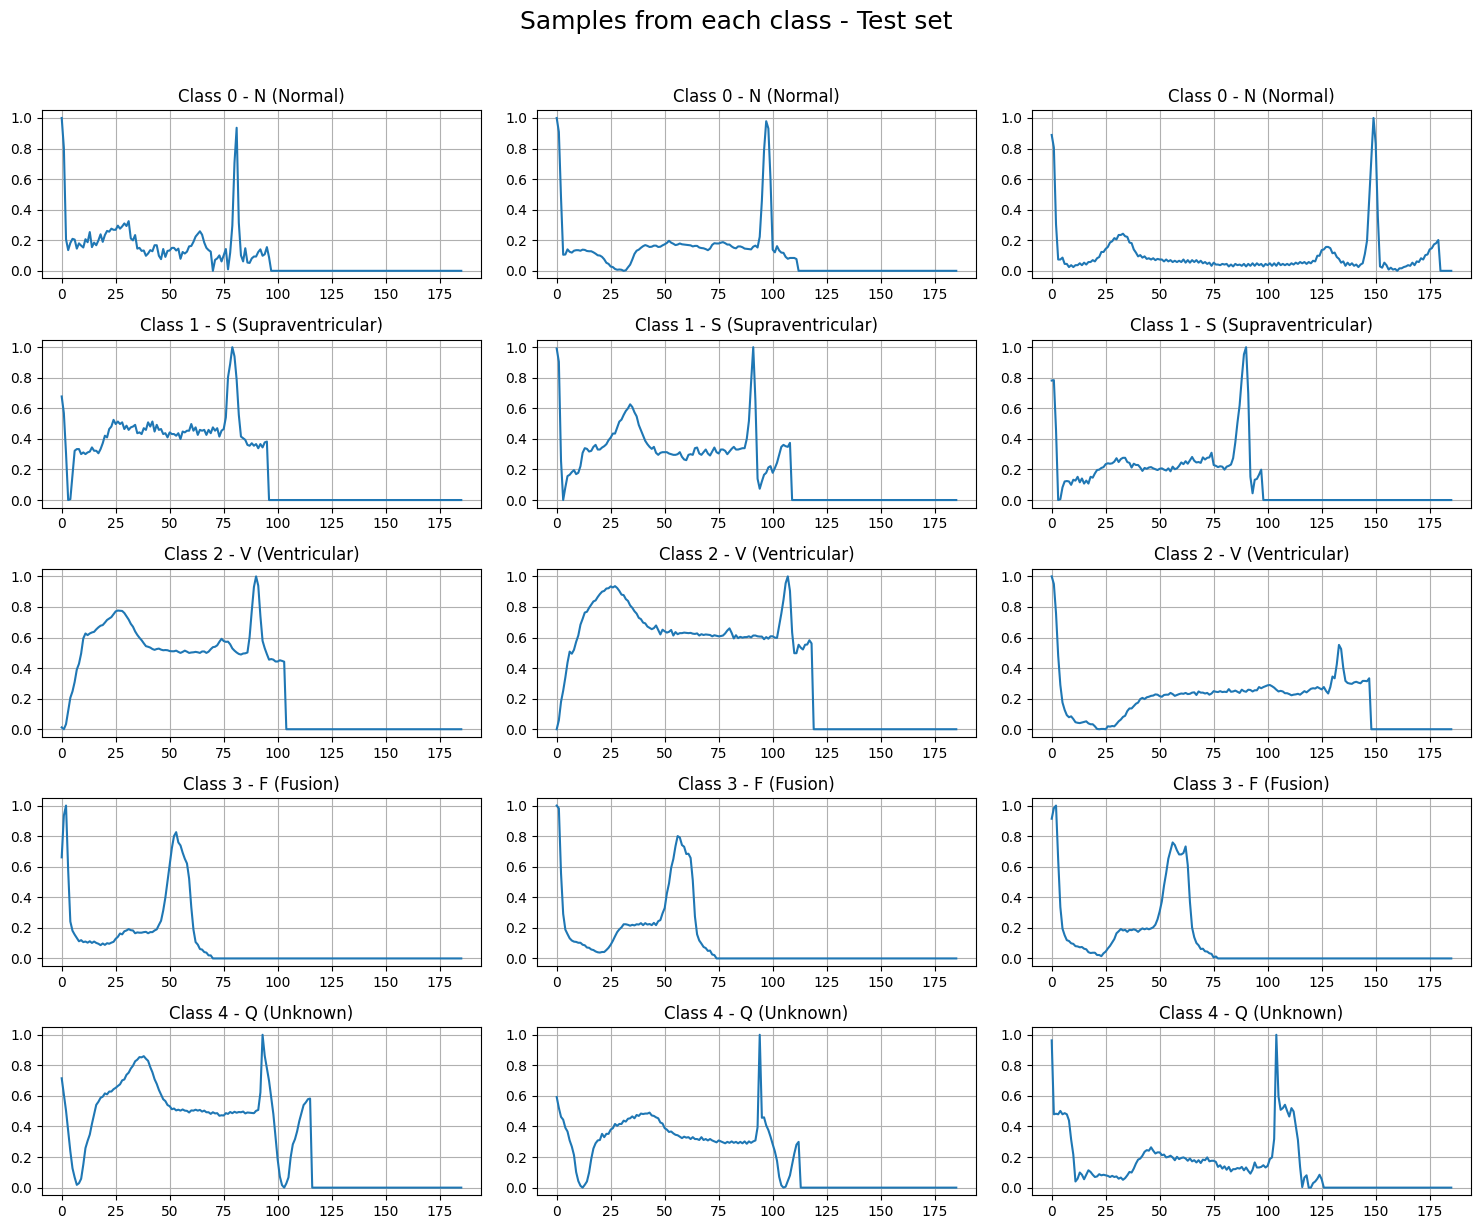

In [ ]:


def show_samples_per_class(df, title, samples_per_class=3):
    fig, axes = plt.subplots(5, samples_per_class, figsize=(samples_per_class*5, 12))
    fig.suptitle(title, fontsize=18, y=1.02)

    class_names = ["N (Normal)", "S (Supraventricular)", "V (Ventricular)", "F (Fusion)", "Q (Unknown)"]

    for cls in range(5):
        cls_samples = df[df[187] == cls].sample(n=samples_per_class, random_state=cls)

        for i in range(samples_per_class):
            signal = cls_samples.iloc[i, :186].values
            axes[cls, i].plot(signal)
            axes[cls, i].set_title(f'Class {cls} - {class_names[cls]}')
            axes[cls, i].grid(True)

    plt.tight_layout()
    plt.show()

show_samples_per_class(train_df, "Samples from each class - Train set", samples_per_class=3)
show_samples_per_class(test_df,  "Samples from each class - Test set",  samples_per_class=3)

**Balance of dataset**

In [ ]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)


187
0    72471
4     6431
2     5788
1     2223
3      641
Name: count, dtype: int64


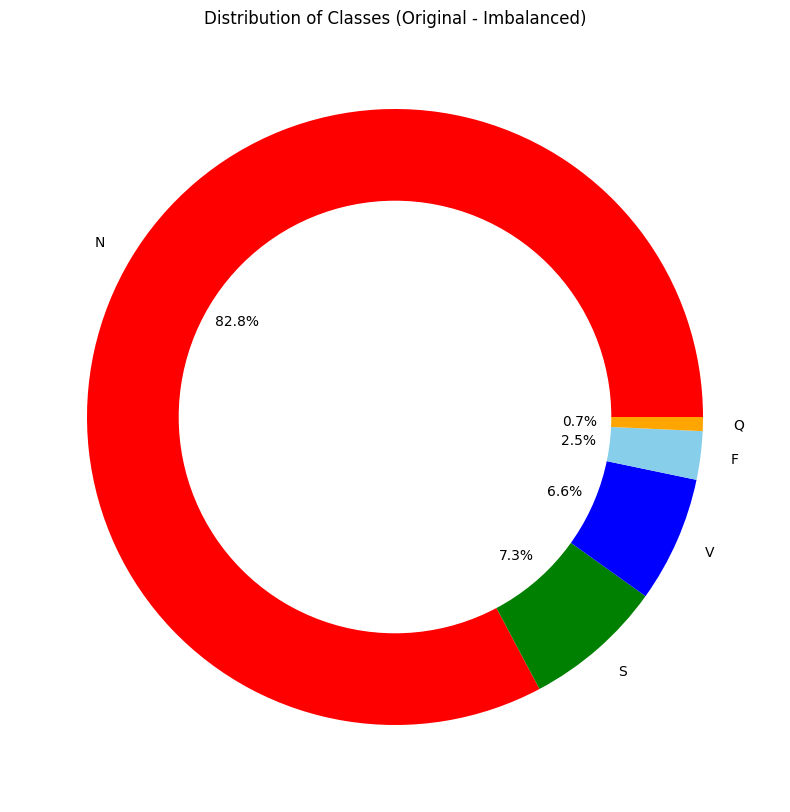

In [ ]:
equilibre = train_df[187].value_counts()

plt.figure(figsize=(10,10))
my_circle = plt.Circle((0,0), 0.7, color='white')
plt.pie(equilibre, labels=['N','S','V','F','Q'],
        colors=['red','green','blue','skyblue','orange'], autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Distribution of Classes (Original - Imbalanced)")
plt.show()

In [ ]:
train_set, val_set = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df[187])

df_0 = train_set[train_set[187] == 0]
df_1 = train_set[train_set[187] == 1]
df_2 = train_set[train_set[187] == 2]
df_3 = train_set[train_set[187] == 3]
df_4 = train_set[train_set[187] == 4]

n_samples = len(df_0)

df_1_upsampled = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_upsampled = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_upsampled = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_upsampled = resample(df_4, replace=True, n_samples=n_samples, random_state=42)

train_balanced = pd.concat([df_0, df_1_upsampled, df_2_upsampled, df_3_upsampled, df_4_upsampled])

print("Data processing complete.")
print(f"Original Train size: {len(train_set)}")
print(f"Balanced Train size: {len(train_balanced)}")
print(f"Validation size (Untouched): {len(val_set)}")

Data processing complete.
Original Train size: 70043
Balanced Train size: 289885
Validation size (Untouched): 17511


In [ ]:
def preprocess_input(df):
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

    X = X.reshape(X.shape[0], X.shape[1], 1)

    y = to_categorical(y)
    return X, y

X_train, y_train = preprocess_input(train_balanced)
X_val, y_val = preprocess_input(val_set)
X_test, y_test = preprocess_input(test_df)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (289885, 187, 1)
X_val shape: (17511, 187, 1)
X_test shape: (21892, 187, 1)


In [ ]:
equilibre=train_df[187].value_counts()
print(equilibre)


187
0    72471
4     6431
2     5788
1     2223
3      641
Name: count, dtype: int64


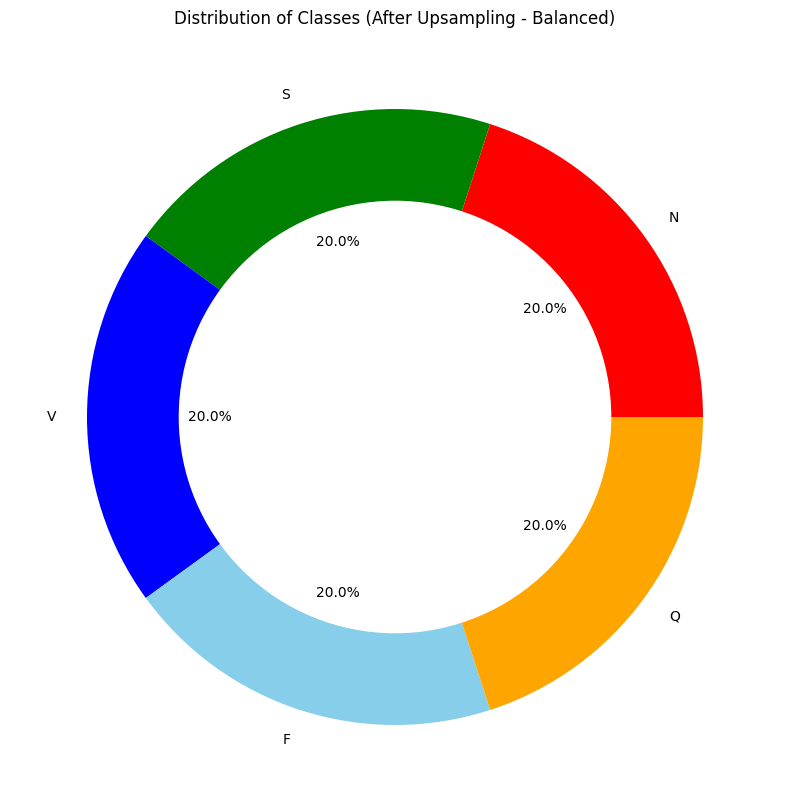

In [ ]:
equilibre_balanced = train_balanced[187].value_counts()

plt.figure(figsize=(10,10))
my_circle = plt.Circle((0,0), 0.7, color='white')
plt.pie(equilibre_balanced, labels=['N','S','V','F','Q'],
        colors=['red','green','blue','skyblue','orange'], autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Distribution of Classes (After Upsampling - Balanced)")
plt.show()

In [ ]:
def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),

        Conv1D(64, 6, activation='relu'),
        BatchNormalization(),
        MaxPool1D(pool_size=3, strides=2, padding="same"),

        Conv1D(64, 3, activation='relu'),
        BatchNormalization(),
        MaxPool1D(pool_size=2, strides=2, padding="same"),

        Conv1D(64, 3, activation='relu'),
        BatchNormalization(),
        MaxPool1D(pool_size=2, strides=2, padding="same"),

        Flatten(),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),

        Dense(5, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model(input_shape=(X_train.shape[1], 1))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 182, 64)        │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 182, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 91, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 89, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 89, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 43, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 43, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        90,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,341 (462.27 KB)

 Trainable params: 117,957 (460.77 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/50
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9335 - loss: 0.1880
Epoch 1: val_loss improved from inf to 0.17039, saving model to best_model.keras
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.9335 - loss: 0.1880 - val_accuracy: 0.9472 - val_loss: 0.1704
Epoch 2/50
9046/9059 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9884 - loss: 0.0368
Epoch 2: val_loss improved from 0.17039 to 0.09379, saving model to best_model.keras
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.9884 - loss: 0.0368 - val_accuracy: 0.9788 - val_loss: 0.0938
Epoch 3/50
9047/9059 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9936 - loss: 0.0211
Epoch 3: val_loss did not improve from 0.09379
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.9936 - loss: 0.0211 - val_accuracy: 0.9770 - val_loss: 0.1068
Epoch 4/50
9048/9059 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9956 - loss: 0.0148
Epoch 4: val_loss did not improve from 0.09379
9059/9059 ━━━━━━━━━━━━━━━━━━

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9847 - loss: 0.0541
Test Accuracy: 97.94%
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Classification Report:
                      precision    recall  f1-score   support

          Normal (N)       0.99      0.99      0.99     18118
Supraventricular (S)       0.83      0.82      0.83       556
     Ventricular (V)       0.94      0.95      0.94      1448
          Fusion (F)       0.59      0.90      0.71       162
         Unknown (Q)       0.99      0.99      0.99      1608

            accuracy                           0.98     21892
           macro avg       0.87      0.93      0.89     21892
        weighted avg       0.98      0.98      0.98     21892



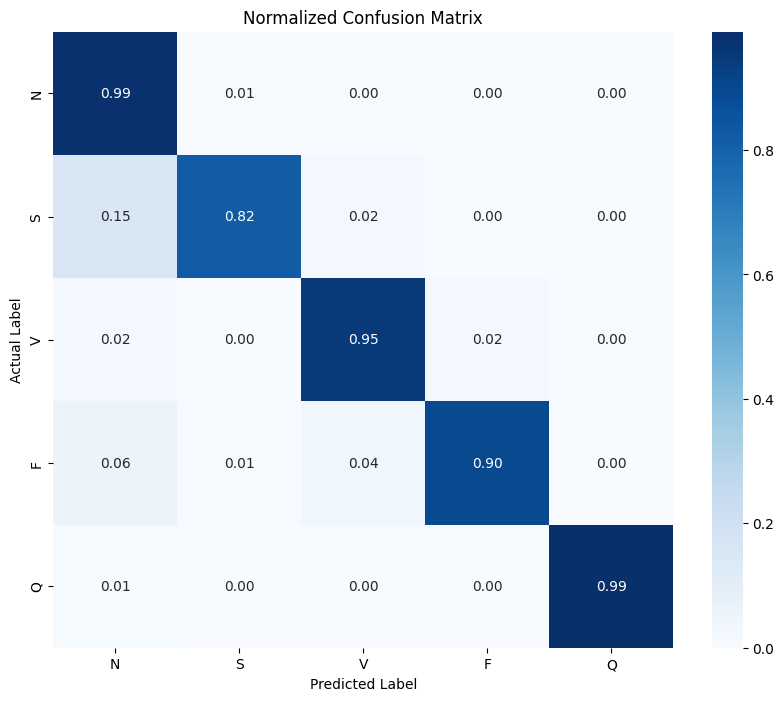

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['Normal (N)', 'Supraventricular (S)', 'Ventricular (V)', 'Fusion (F)', 'Unknown (Q)']))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['N', 'S', 'V', 'F', 'Q'],
            yticklabels=['N', 'S', 'V', 'F', 'Q'])
plt.title('Normalized Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

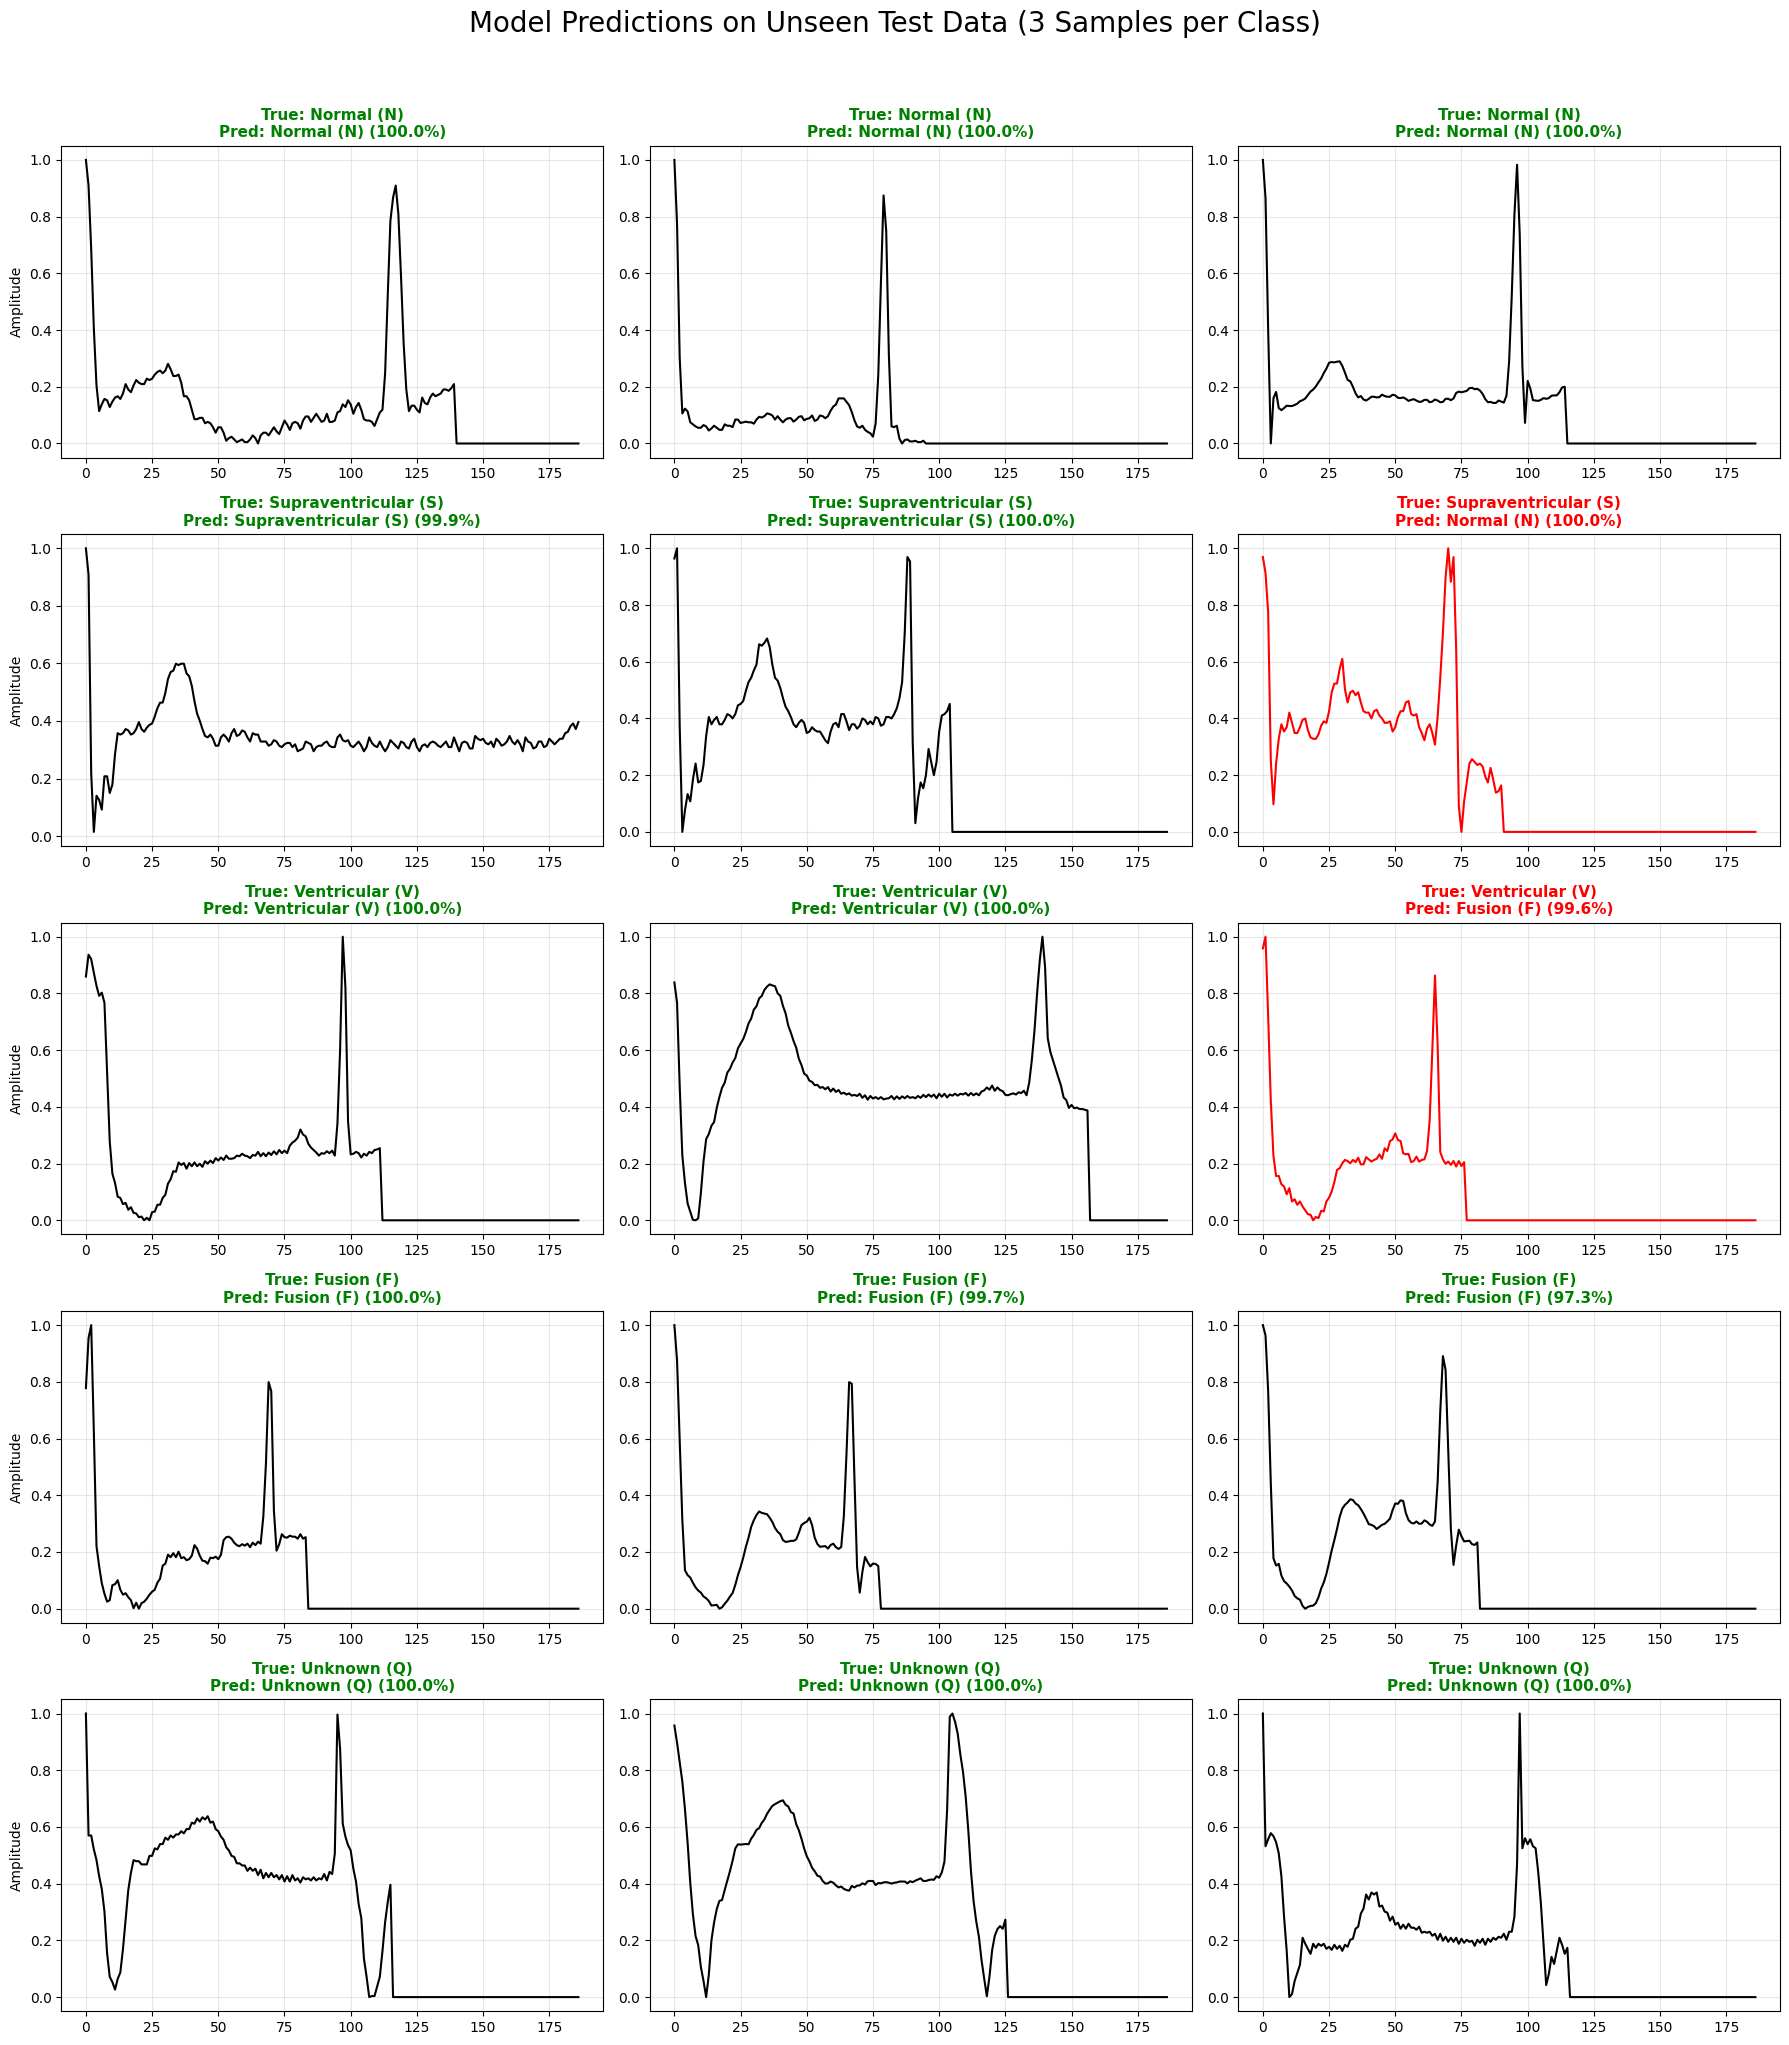

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class_map = {0: 'Normal (N)', 1: 'Supraventricular (S)',
             2: 'Ventricular (V)', 3: 'Fusion (F)', 4: 'Unknown (Q)'}

fig, axes = plt.subplots(5, 3, figsize=(18, 20))
fig.suptitle("Model Predictions on Unseen Test Data (3 Samples per Class)", fontsize=20, y=1.02)
plt.subplots_adjust(hspace=0.5)

for class_id in range(5):
    specific_class_data = test_df[test_df[187] == class_id]

    if len(specific_class_data) < 3:
        print(f"Warning: Not enough samples for class {class_id}")
        continue

    random_samples = specific_class_data.sample(3)

    for i in range(3):
        signal = random_samples.iloc[i, :-1].values
        model_input = signal.reshape(1, 187, 1)

        prediction_prob = model.predict(model_input, verbose=0)
        predicted_class = np.argmax(prediction_prob)
        confidence = np.max(prediction_prob) * 100

        ax = axes[class_id, i]
        ax.plot(signal, color='black' if class_id == predicted_class else 'red')

        title_color = 'green' if class_id == predicted_class else 'red'

        ax.set_title(f"True: {class_map[class_id]}\nPred: {class_map[predicted_class]} ({confidence:.1f}%)",
                     color=title_color, fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)

        if i == 0:
            ax.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [4]:
df_normal = pd.read_csv(os.path.join(path, 'ptbdb_normal.csv'), header=None)
df_abnormal = pd.read_csv(os.path.join(path, 'ptbdb_abnormal.csv'), header=None)
df_ptb = pd.concat([df_normal, df_abnormal], axis=0)
df_ptb.columns = [f'sample_{i}' for i in range(df_ptb.shape[1]-1)] + ['label']

In [5]:
def trim_padding(signal):
    signal = np.array(signal)
    last_nonzero = np.max(np.nonzero(signal)) if np.any(signal != 0) else 0
    return signal[:last_nonzero + 1]

In [6]:
X_ptb = []
y_ptb = df_ptb['label'].values.astype(int)
for i in range(len(df_ptb)):
    signal = df_ptb.iloc[i, :-1].values
    trimmed = trim_padding(signal)
    X_ptb.append(trimmed)

max_len_ptb = max(len(s) for s in X_ptb)
print(f"Maximum signal length: {max_len_ptb}")

Maximum signal length: 186


In [7]:
X_ptb_padded = np.array([np.pad(s, (0, max_len_ptb - len(s)), 'constant') for s in X_ptb])
X_ptb_padded = X_ptb_padded[..., np.newaxis]

X_ptb_train, X_ptb_test, y_ptb_train, y_ptb_test = train_test_split(X_ptb_padded, y_ptb, test_size=0.2, random_state=42, stratify=y_ptb)

num_classes = 2
y_ptb_train_cat = to_categorical(y_ptb_train, num_classes=num_classes)
y_ptb_test_cat = to_categorical(y_ptb_test, num_classes=num_classes)


In [11]:
from tensorflow.keras.layers import MaxPooling1D
model_ptb = Sequential()
model_ptb.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(max_len_ptb, 1)))
model_ptb.add(MaxPooling1D(pool_size=2))
model_ptb.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model_ptb.add(MaxPooling1D(pool_size=2))
model_ptb.add(Flatten())
model_ptb.add(Dense(128, activation='relu'))
model_ptb.add(Dropout(0.5))
model_ptb.add(Dense(num_classes, activation='softmax'))

model_ptb.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_ptb = model_ptb.fit(X_ptb_train, y_ptb_train_cat, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7677 - loss: 0.4685 - val_accuracy: 0.8557 - val_loss: 0.3248
Epoch 2/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8476 - loss: 0.3407 - val_accuracy: 0.8695 - val_loss: 0.2886
Epoch 3/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8882 - loss: 0.2675 - val_accuracy: 0.8643 - val_loss: 0.2696
Epoch 4/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9165 - loss: 0.2082 - val_accuracy: 0.9438 - val_loss: 0.1566
Epoch 5/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9336 - loss: 0.1781 - val_accuracy: 0.9463 - val_loss: 0.1435
Epoch 6/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9380 - loss: 0.1591 - val_accuracy: 0.9553 - val_loss: 0.1174
Epoch 7/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9541 - loss: 0.1367 - val_accuracy: 0.9657 - val_loss: 0.0984
Epoch 8/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9657 - loss: 0.1057 - val_accuracy: 0.

In [12]:
loss, acc = model_ptb.evaluate(X_ptb_test, y_ptb_test_cat)
print(f'PTBDB Test Loss: {loss}')
print(f'PTBDB Test Accuracy: {acc}')

y_pred_ptb = np.argmax(model_ptb.predict(X_ptb_test), axis=1)
print(classification_report(y_ptb_test, y_pred_ptb, target_names=['Normal', 'Abnormal']))

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9874 - loss: 0.0485
PTBDB Test Loss: 0.06826324015855789
PTBDB Test Accuracy: 0.9855719804763794
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

      Normal       0.98      0.97      0.97       809
    Abnormal       0.99      0.99      0.99      2102

    accuracy                           0.99      2911
   macro avg       0.98      0.98      0.98      2911
weighted avg       0.99      0.99      0.99      2911



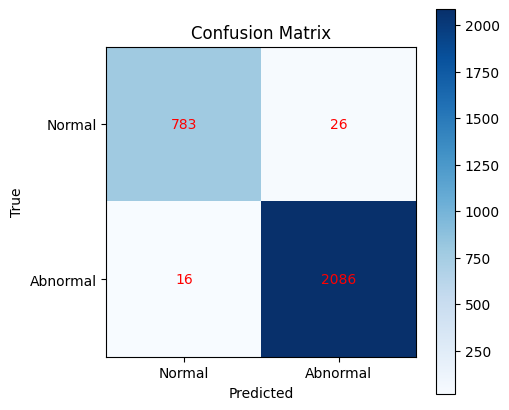

In [15]:
cm = confusion_matrix(y_ptb_test, y_pred_ptb)
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0,1], ['Normal', 'Abnormal'])
plt.yticks([0,1], ['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('True')
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

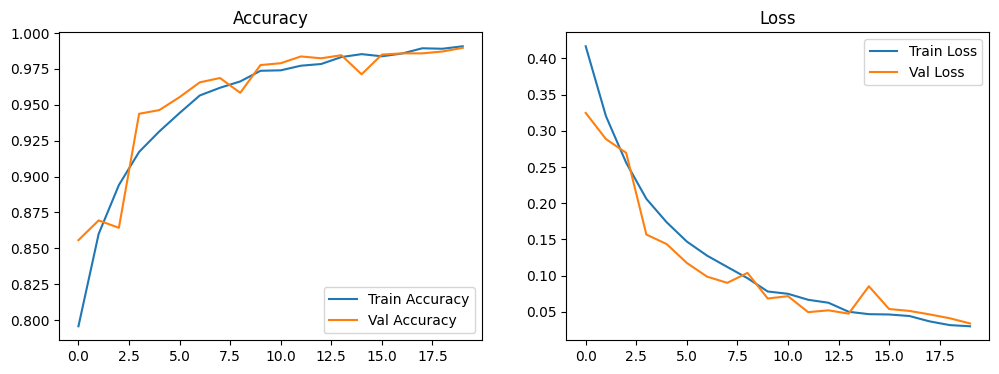

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_ptb.history['accuracy'], label='Train Accuracy')
plt.plot(history_ptb.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_ptb.history['loss'], label='Train Loss')
plt.plot(history_ptb.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

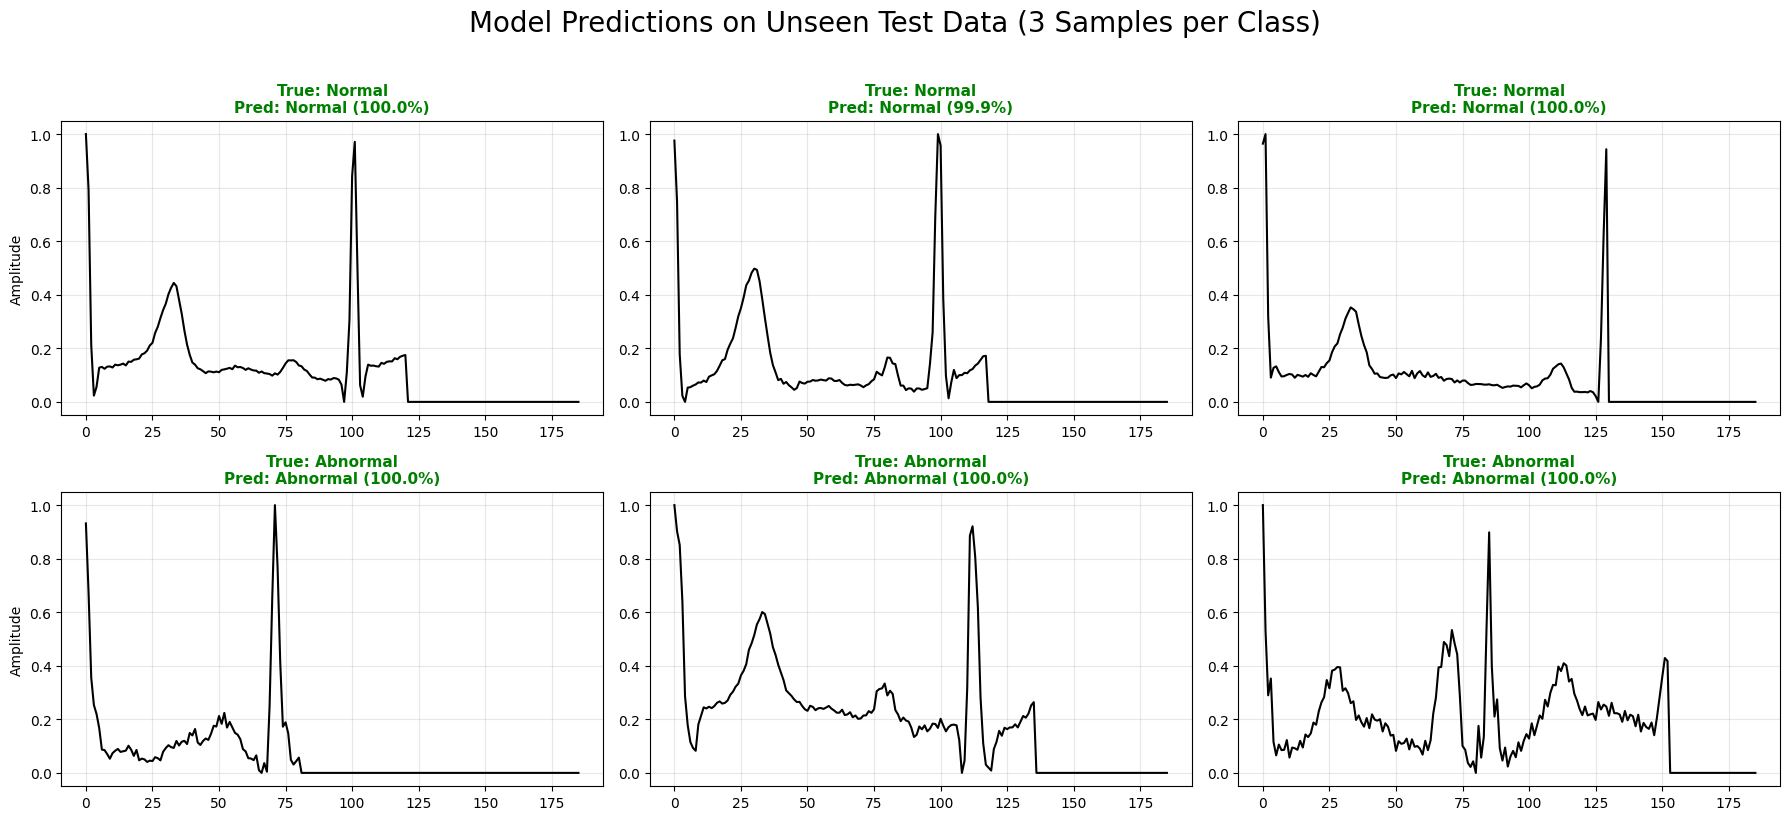

In [21]:

test_signals = X_ptb_test.squeeze()
test_df = pd.DataFrame(test_signals)
test_df['label'] = y_ptb_test

class_map = {0: 'Normal', 1: 'Abnormal'}

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle("Model Predictions on Unseen Test Data (3 Samples per Class)", fontsize=20, y=1.02)
plt.subplots_adjust(hspace=0.5)

for class_id in range(2):
    specific_class_data = test_df[test_df['label'] == class_id]

    if len(specific_class_data) < 3:
        print(f"Warning: Not enough samples for class {class_id}")
        continue

    random_samples = specific_class_data.sample(3)

    for i in range(3):
        signal = random_samples.iloc[i, :-1].values
        model_input = signal.reshape(1, len(signal), 1)

        prediction_prob = model_ptb.predict(model_input, verbose=0)
        predicted_class = np.argmax(prediction_prob)
        confidence = np.max(prediction_prob) * 100

        ax = axes[class_id, i]
        ax.plot(signal, color='black' if class_id == predicted_class else 'red')

        title_color = 'green' if class_id == predicted_class else 'red'

        ax.set_title(f"True: {class_map[class_id]}\nPred: {class_map[predicted_class]} ({confidence:.1f}%)",
                     color=title_color, fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)

        if i == 0:
            ax.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

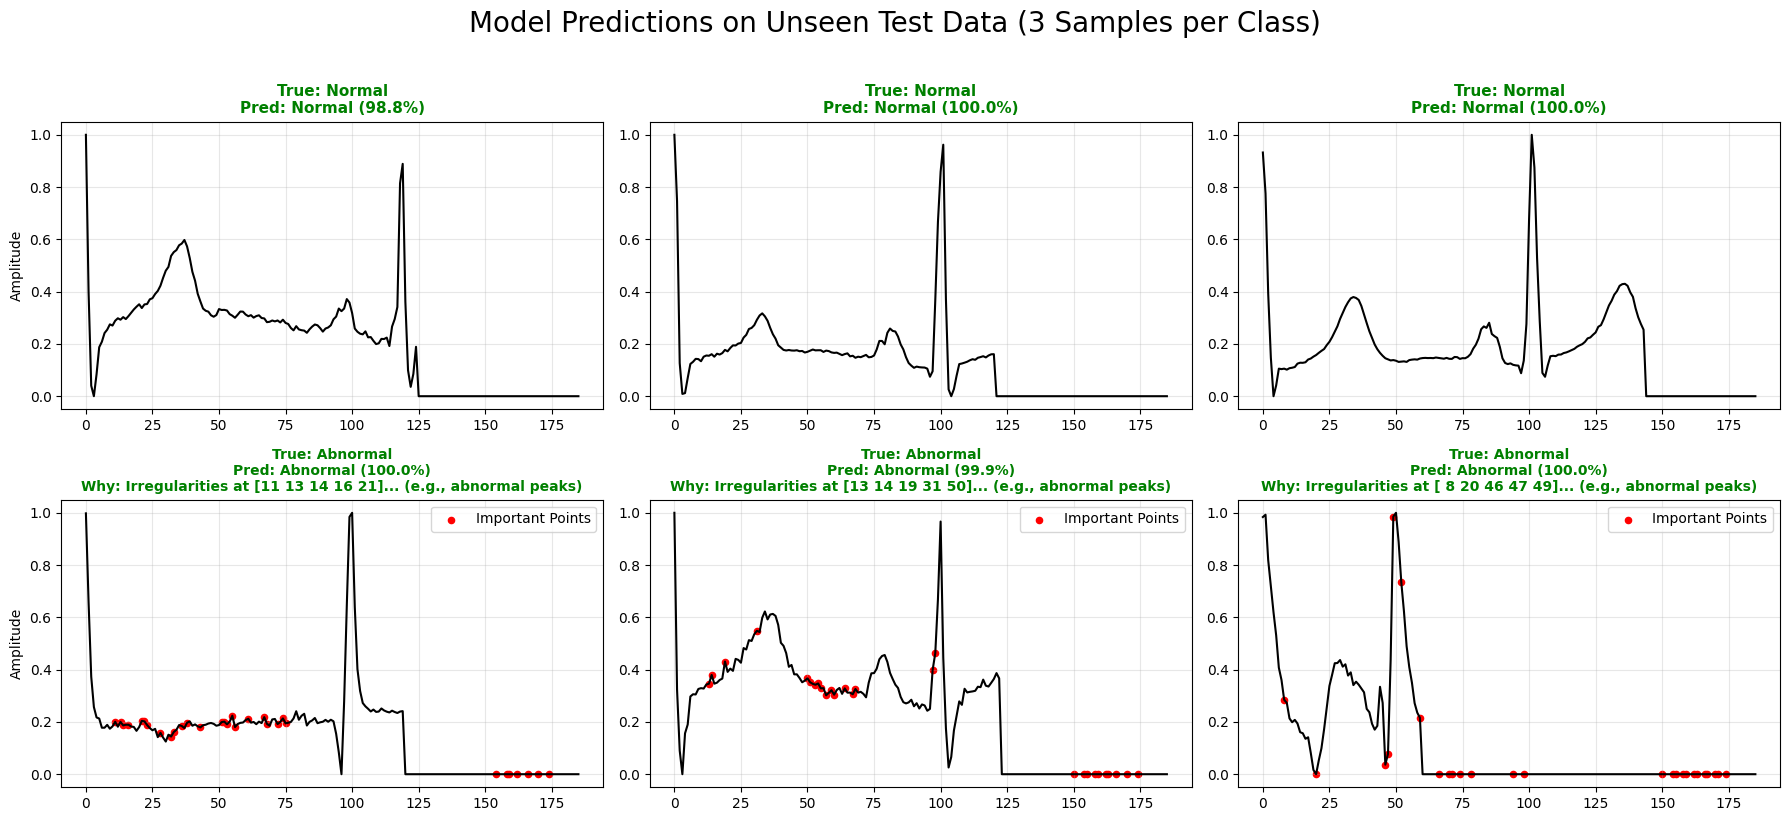

In [24]:
test_signals = X_ptb_test.squeeze()
test_df = pd.DataFrame(test_signals)
test_df['label'] = y_ptb_test

class_map = {0: 'Normal', 1: 'Abnormal'}

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle("Model Predictions on Unseen Test Data (3 Samples per Class)", fontsize=20, y=1.02)
plt.subplots_adjust(hspace=0.5)

for class_id in range(2):
    specific_class_data = test_df[test_df['label'] == class_id]

    if len(specific_class_data) < 3:
        print(f"Warning: Not enough samples for class {class_id}")
        continue

    random_samples = specific_class_data.sample(3)

    for i in range(3):
        signal = random_samples.iloc[i, :-1].values
        model_input = tf.convert_to_tensor(signal.reshape(1, len(signal), 1), dtype=tf.float32)

        prediction_prob = model_ptb.predict(model_input, verbose=0)
        predicted_class = np.argmax(prediction_prob)
        confidence = np.max(prediction_prob) * 100

        ax = axes[class_id, i]
        ax.plot(signal, color='black' if class_id == predicted_class else 'red')

        title_color = 'green' if class_id == predicted_class else 'red'

        title = f"True: {class_map[class_id]}\nPred: {class_map[predicted_class]} ({confidence:.1f}%)"
        ax.set_title(title, color=title_color, fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)

        if i == 0:
            ax.set_ylabel("Amplitude")

        if predicted_class == 1:
            with tf.GradientTape() as tape:
                tape.watch(model_input)
                preds = model_ptb(model_input)
                class_idx = tf.argmax(preds[0])
                output = preds[:, class_idx]

            grads = tape.gradient(output, model_input)
            saliency = tf.abs(grads)[0, :, 0].numpy()

            threshold = np.mean(saliency) + np.std(saliency)
            important_points = np.where(saliency > threshold)[0]

            ax.scatter(important_points, signal[important_points], color='red', s=20, label='Important Points')
            ax.legend()

            why_text = f"\nWhy: Irregularities at {important_points[:5]}... (e.g., abnormal peaks)"
            ax.set_title(title + why_text, color=title_color, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()